Testing

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# Avoiding warnings

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
dublin_trips_per_time = pd.read_csv('dublin_trips_per_time.csv')

In [3]:
dublin_trips_per_time.tail()

,station_id,station,time,weekday,month,week,day,hour,total_trips_per_station
1948266,507,ORIEL STREET TEST TERMINAL,2022-04-20 08:30:02,3,4,16,20,8,0
1948267,507,ORIEL STREET TEST TERMINAL,2022-04-20 09:00:02,3,4,16,20,9,0
1948268,507,ORIEL STREET TEST TERMINAL,2022-04-20 09:30:03,3,4,16,20,9,0
1948269,507,ORIEL STREET TEST TERMINAL,2022-04-20 10:00:02,3,4,16,20,10,0
1948270,507,ORIEL STREET TEST TERMINAL,2022-04-20 10:30:02,3,4,16,20,10,0


In [4]:
dublin_trips_per_time = dublin_trips_per_time[dublin_trips_per_time['total_trips_per_station']>0]

In [5]:
dublin_trips_per_time.tail()

,station_id,station,time,weekday,month,week,day,hour,total_trips_per_station
1947299,117,HANOVER QUAY EAST,2022-12-31 17:00:03,6,12,52,31,17,1
1947303,117,HANOVER QUAY EAST,2022-12-31 19:00:02,6,12,52,31,19,2
1947304,117,HANOVER QUAY EAST,2022-12-31 19:30:02,6,12,52,31,19,2
1947307,117,HANOVER QUAY EAST,2022-12-31 21:00:02,6,12,52,31,21,1
1947311,117,HANOVER QUAY EAST,2022-12-31 23:00:03,6,12,52,31,23,1


In [6]:
dublin_trips_per_time = dublin_trips_per_time[['station_id', 'month', 'total_trips_per_station']]

In [7]:
dublin_trips_per_time.head()

,station_id,month,total_trips_per_station
297,1,5,1
299,1,5,1
300,1,5,1
302,1,5,4
304,1,5,3


In [8]:
dublin_trips_per_time = dublin_trips_per_time.groupby(['station_id', 'month'])['total_trips_per_station'].sum().reset_index()

In [9]:
dublin_trips_per_time.head(30)

,station_id,month,total_trips_per_station
0,1,5,1019
1,1,6,1384
2,1,7,1969
3,1,8,1980
4,1,9,1666
5,1,10,1931
6,1,11,1822
7,1,12,1769
8,2,1,1163
9,2,2,1313


In [10]:
X = dublin_trips_per_time[['station_id', 'month']]
y = dublin_trips_per_time['total_trips_per_station']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
y_pred = xgb_reg.predict(X_test)

In [14]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 79621.04142771066


In [15]:
param_grid = {'n_estimators': [100, 200],'learning_rate': [0.1, 0.3],'max_depth': [5, 7],'min_child_weight': [1, 3],'subsample': [0.8, 1.0],'colsample_bytree': [0.8, 1.0],'reg_alpha': [0, 0.1, 0.5],'reg_lambda': [1, 1.5, 2]}

grid_search = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error after tuning: {mse}")

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.5, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.5, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_la

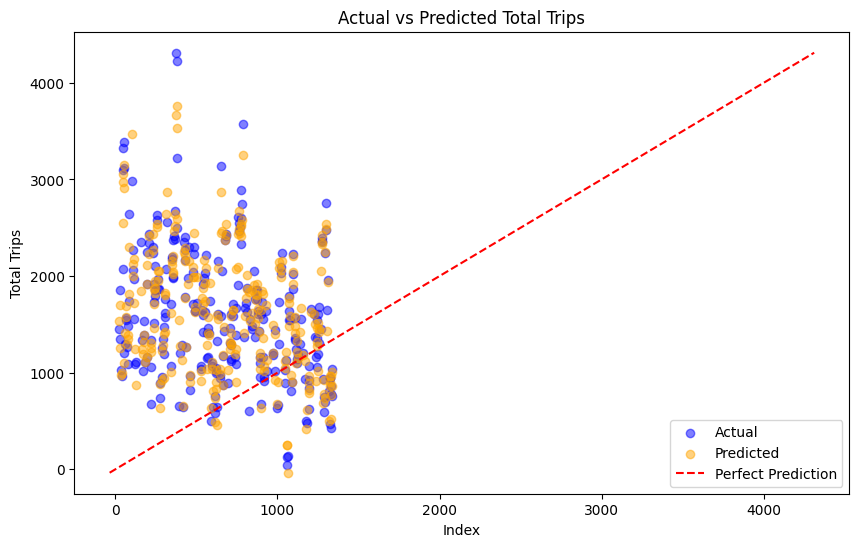

In [16]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, color='blue', alpha=0.5, label='Actual')
plt.scatter(X_test.index, y_pred, color='orange', alpha=0.5, label='Predicted')

# Line of perfect prediction
perfect_line = np.linspace(min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max()), 100)
plt.plot(perfect_line, perfect_line, color='red', linestyle='--', label='Perfect Prediction')

# Labels and title
plt.xlabel("Index")
plt.ylabel("Total Trips")
plt.title("Actual vs Predicted Total Trips")
plt.legend()
plt.show()

In [20]:
test_df = X_test.copy()
test_df['actual'] = y_test.values
test_df['predicted'] = y_pred


In [18]:
monthly_actual = test_df.groupby('month')['actual'].sum().reset_index()
monthly_predicted = test_df.groupby('month')['predicted'].sum().reset_index()

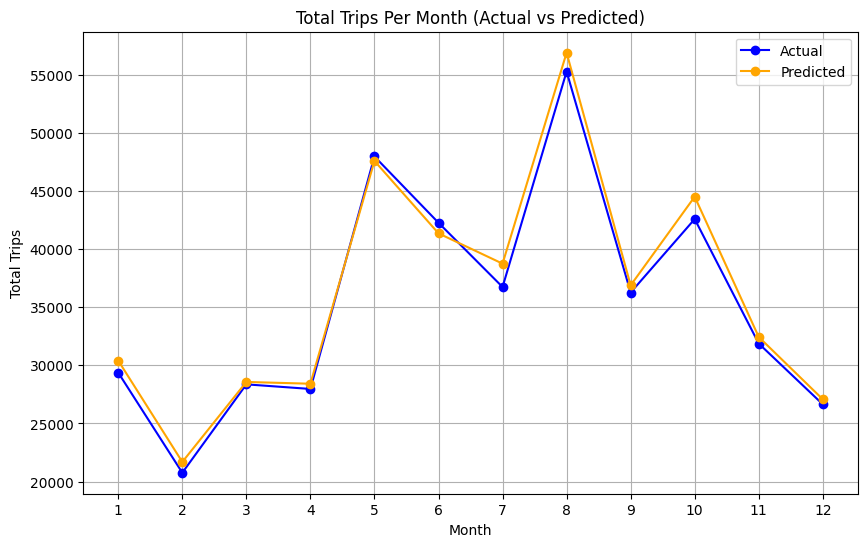

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(monthly_actual['month'], monthly_actual['actual'], marker='o', linestyle='-', color='b', label='Actual')
plt.plot(monthly_predicted['month'], monthly_predicted['predicted'], marker='o', linestyle='-', color='orange', label='Predicted')
plt.xlabel('Month')
plt.ylabel('Total Trips')
plt.title('Total Trips Per Month (Actual vs Predicted)')
plt.xticks(monthly_actual['month'])  # Ensure all months are labeled on the x-axis
plt.grid(True)
plt.legend()
plt.show()